# RMSProp

:label:`chapter_rmsprop`


In the experiment in :numref:`chapter_adagrad`, the learning rate of each element in the independent variable of the objective function declines (or remains unchanged) during iteration because the variable $\mathbf{s}_t$ in the denominator is increased by the square by element operation of the mini-batch stochastic gradient, adjusting the learning rate. Therefore, when the learning rate declines very fast during early iteration, yet the current solution is still not desirable, Adagrad might have difficulty finding a useful solution because the learning rate will be too small at later stages of iteration. To tackle this problem, the RMSProp algorithm made a small modification to Adagrad[1].

## The Algorithm

Unlike in Adagrad, the state variable
$\mathbf{s}_t$ is the sum of the square by element all the mini-batch
stochastic gradients $\mathbf{g}_t$ up to the time step $t$, RMSProp uses
the exponentially weighted moving average on the square by element results of these gradients. Specifically,
given the hyperparameter $0 \leq \gamma < 1$, RMSProp is computed at time step
$t>0$.

$$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t \odot \mathbf{g}_t. $$

Like Adagrad, RMSProp re-adjusts the learning rate of each element in the independent variable of the objective function with element operations and then updates the independent variable.

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t, $$

Here, $\eta$ is the learning rate while $\epsilon$ is a constant added to maintain numerical stability, such as $10^{-6}$.

### Exponentially Weighted Moving Average (EWMA)

Now let expand the definition of $\mathbf{s}_t$, we can see that

$$
\begin{aligned}
\mathbf{s}_t &= (1 - \gamma) \mathbf{g}_t \odot \mathbf{g}_t + \gamma \mathbf{s}_{t-1} \\
&= (1 - \gamma) \left(\mathbf{g}_t \odot \mathbf{g}_t + \gamma \mathbf{g}_{t-1} \odot \mathbf{g}_{t-1}\right) + \gamma^2 \mathbf{s}_{t-2} \\ &\cdots\\
&= (1 - \gamma)\left( \mathbf{g}_t \odot \mathbf{g}_t + \gamma \mathbf{g}_{t-1} \odot \mathbf{g}_{t-1} + \cdots + \gamma^{t-1}\mathbf{g}_{1} \odot \mathbf{g}_{1} \right).
\end{aligned}
$$

In :numref:`chapter_momentum` we see that $\frac{1}{1-\gamma} = 1 + \gamma + \gamma^2 + \cdots$, so the sum of weights equals to 1. In addition, these weights decrease exponentially, it is called exponentially weighted moving average.

We visualize the weights in the past 40 time steps with various $\gamma$s.

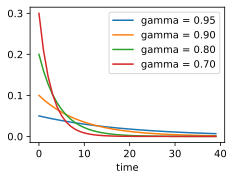

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import math
from mxnet import nd

gammas = [0.95, 0.9, 0.8, 0.7]
d2l.set_figsize()
for gamma in gammas:
    x = nd.arange(40).asnumpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x)
d2l.plt.xlabel('time')
d2l.plt.legend(['gamma = %.2f'%g for g in gammas]);

## Implementation from Scratch

By convention, we will use the objective function
$f(\mathbf{x})=0.1x_1^2+2x_2^2$ to observe the iterative trajectory of the
independent variable in RMSProp. Recall that in
:numref:`chapter_adagrad`, when we used Adagrad with a learning rate of 0.4, the independent
variable moved less in later stages of iteration. However, at the same learning
rate, RMSProp can approach the optimal solution faster.

epoch 20, x1 -0.010599, x2 0.000000


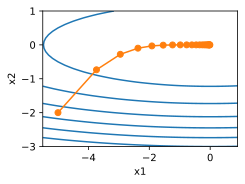

In [2]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

Next, we implement RMSProp with the formula in the algorithm.

In [3]:

features, labels = d2l.get_data_ch7()
def init_rmsprop_states():
    s_w = nd.zeros((features.shape[1], 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

We set the initial learning rate to 0.01 and the hyperparameter $\gamma$ to 0.9. Now, the variable $\boldsymbol{s}_t$ can be treated as the weighted average of the square term $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ from the last $1/(1-0.9) = 10$ time steps.

loss: 0.242850, 0.282696 sec per epoch


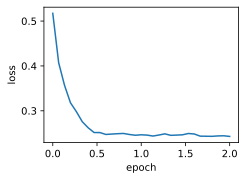

In [4]:
d2l.train_ch9(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

## Concise Implementation

From the `Trainer` instance of the algorithm named "rmsprop", we can implement the RMSProp algorithm with Gluon to train models. Note that the hyperparameter $\gamma$ is assigned by `gamma1`.

loss: 0.246084, 0.182093 sec per epoch


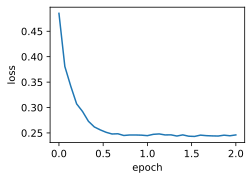

In [5]:
d2l.train_gluon_ch9('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9},
                    features, labels)

## Summary

* The difference between RMSProp and Adagrad is that RMSProp uses an EWMA on the squares of elements in the mini-batch stochastic gradient to adjust the learning rate.

## Exercises

* What happens to the experimental results if we set the value of $\gamma$ to 1? Why?
* Try using other combinations of initial learning rates and $\gamma$ hyperparameters and observe and analyze the experimental results.




## Reference

[1] Tieleman, T., & Hinton, G. (2012). Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural networks for machine learning, 4(2), 26-31.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2376)

![](../img/qr_rmsprop.svg)